### Loading and Visualizing Images

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading image paths

In [2]:
from imutils import paths

instance_images_root = '/content/drive/MyDrive/DeepLearning/dataset/cthulhu/cthulhu_instance_images'
class_images_root = '/content/drive/MyDrive/DeepLearning/dataset/cthulhu/cthulhu_class_images'

instance_image_paths = list(paths.list_images(instance_images_root))
class_image_paths = list(paths.list_images(class_images_root))

instance_image_paths, class_image_paths[:5]

(['/content/drive/MyDrive/DeepLearning/dataset/cthulhu/cthulhu_instance_images/cthulhu_3.jpg',
  '/content/drive/MyDrive/DeepLearning/dataset/cthulhu/cthulhu_instance_images/Cthulhu_5.jpg',
  '/content/drive/MyDrive/DeepLearning/dataset/cthulhu/cthulhu_instance_images/cthulhu_1.jpg',
  '/content/drive/MyDrive/DeepLearning/dataset/cthulhu/cthulhu_instance_images/cthulhu_2.jpg',
  '/content/drive/MyDrive/DeepLearning/dataset/cthulhu/cthulhu_instance_images/cthulhu_4.jpg'],
 ['/content/drive/MyDrive/DeepLearning/dataset/cthulhu/cthulhu_class_images/23de8b939675eb781f4a85d1d5b0046d98b3c9bc.jpg',
  '/content/drive/MyDrive/DeepLearning/dataset/cthulhu/cthulhu_class_images/e81868ea0d9a171649bc0098e7e1187f1335207b.jpg',
  '/content/drive/MyDrive/DeepLearning/dataset/cthulhu/cthulhu_class_images/40d345dede30745fd4cf7a4936ee2a9d10dba80e.jpg',
  '/content/drive/MyDrive/DeepLearning/dataset/cthulhu/cthulhu_class_images/0e9c559db2d9ec206ccd0e7805465de6c2412444.jpg',
  '/content/drive/MyDrive/DeepLe

Creating a function that loads images from the paths



In [3]:
from PIL import Image
import numpy as np

def load_images(image_paths):
    images = []
    for path in image_paths:
        image = Image.open(path)
        images.append(np.array(image))
    return images

Creating a function to plot the loaded images

In [4]:
import matplotlib.pyplot as plt

def plot_images(images, title=None):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        if title is not None:
            plt.title(title)
        plt.imshow(images[i])
        plt.axis("off")

**Instance Images**

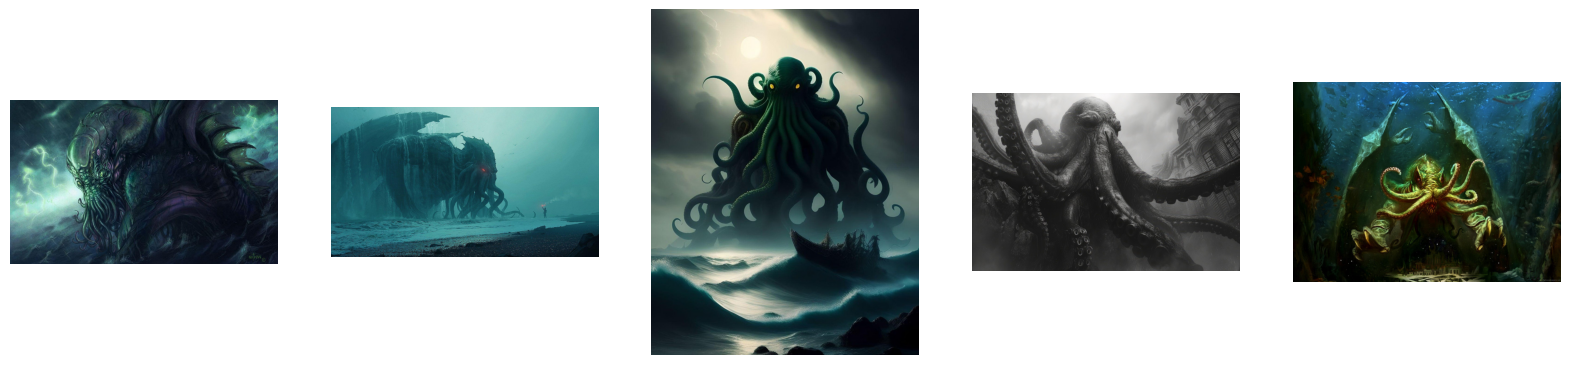

In [5]:
plot_images(load_images(instance_image_paths[:5]))

**Class Images**

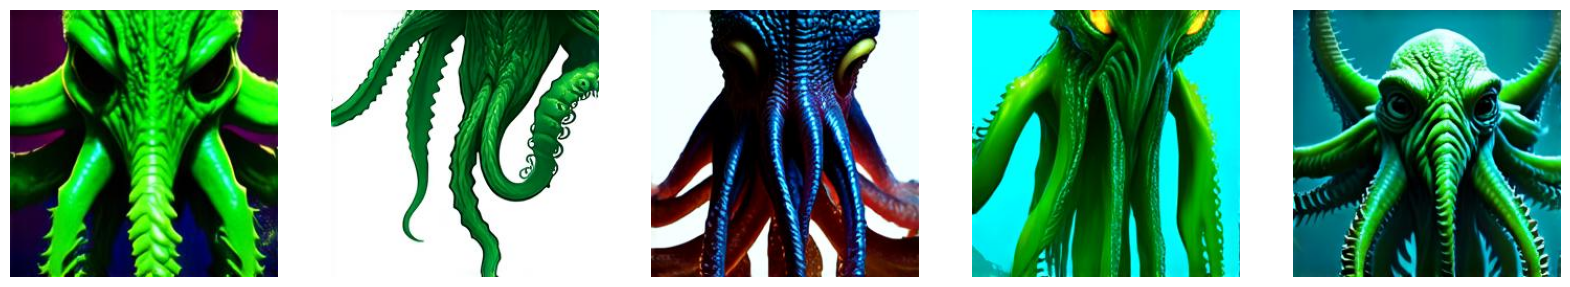

In [6]:
plot_images(load_images(class_image_paths[:5]))

### Dataset Preparation

Prepare Captions

In [7]:
# Since we're using prior preservation, we need to match the number
# of instance images we're using. We just repeat the instance image paths
# to do so.
new_instance_image_paths = []
for index in range(len(class_image_paths)):
    instance_image = instance_image_paths[index % len(instance_image_paths)]
    new_instance_image_paths.append(instance_image)

In [8]:
# We just repeat the prompts / captions per images.
unique_id = "sks"
class_label = "cthulhu"

instance_prompt = f"a photo of {unique_id} {class_label}"
instance_prompts = [instance_prompt] * len(new_instance_image_paths)

class_prompt = f"a photo of {class_label}"
class_prompts = [class_prompt] * len(class_image_paths)

Install Keras Hub

In [9]:
!pip install --upgrade keras-hub
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # Or "tensorflow" or "torch"!
import keras_hub
import tensorflow as tf

Embed prompts to save compute

In [12]:
import tensorflow as tf
import tensorflow_hub as hub
import itertools
import numpy as np
import keras_cv

# Set resolution and parallelism options
resolution = 512
auto = tf.data.AUTOTUNE

# Image Augmentation Pipeline
augmenter = keras_cv.layers.Augmenter(
    layers=[
        tf.keras.layers.Lambda(lambda x: tf.image.resize_with_crop_or_pad(x, resolution, resolution)),  # Center crop equivalent
        keras_cv.layers.RandomFlip(),
        tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ]
)

# Combine all prompts into a single list
all_prompts = list(itertools.chain(instance_prompts, class_prompts))

# Load BERT preprocessor and encoder from TensorFlow Hub
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="preprocessing")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", name="BERT_encoder")

# Preprocess the text (tokenization, padding, masks)
preprocessed_inputs = bert_preprocess(tf.constant(all_prompts))

# Compute embeddings using the BERT encoder
gpus = tf.config.list_logical_devices("GPU")
device_name = gpus[0].name if gpus else "/CPU:0"

with tf.device(device_name):
    outputs = bert_encoder(preprocessed_inputs)
    embedded_text = outputs["pooled_output"].numpy()  # Sentence-level embeddings

# Output the shape of the embeddings
print("Shape of embedded text:", embedded_text.shape)  # (num_prompts, 768)

# Free GPU memory
del bert_encoder

# Image Processing Function
def process_image(image_path, tokenized_text):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, 3)
    image = tf.image.resize(image, (resolution, resolution))
    image = tf.cast(image, tf.float32)  # Convert to float32 after resizing for neural network input
    return image, tokenized_text

# Augment images and extract text embeddings
def apply_augmentation(image_batch, embedded_tokens):
    augmented_images = augmenter(image_batch)  # Apply augmentation
    return augmented_images, embedded_tokens

# Prepare the batch dictionary (either instance or class data)
def prepare_dict(instance_only=True):
    def fn(image_batch, embedded_tokens):
        if instance_only:
            batch_dict = {
                "instance_images": image_batch,
                "instance_embedded_texts": embedded_tokens,
            }
            return batch_dict
        else:
            batch_dict = {
                "class_images": image_batch,
                "class_embedded_texts": embedded_tokens,
            }
            return batch_dict
    return fn

# Assemble the dataset
def assemble_dataset(
    image_paths, embedded_texts, instance_only=True, batch_size=1
):
    dataset = tf.data.Dataset.from_tensor_slices(
        (image_paths, embedded_texts)
    )
    dataset = dataset.map(process_image, num_parallel_calls=auto)
    dataset = dataset.shuffle(5, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)

    # Apply image augmentation and embed text and image features
    dataset = dataset.map(lambda x, y: apply_augmentation(x, y), num_parallel_calls=auto)
    dataset = dataset.map(lambda x, y: (x, y), num_parallel_calls=auto)

    prepare_dict_fn = prepare_dict(instance_only=instance_only)
    dataset = dataset.map(prepare_dict_fn, num_parallel_calls=auto)

    # Prefetch to improve training speed
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset


Shape of embedded text: (400, 768)


In [13]:
instance_dataset = assemble_dataset(
    new_instance_image_paths,
    embedded_text[:len(new_instance_image_paths)],
)
class_dataset = assemble_dataset(
    class_image_paths,
    embedded_text[len(new_instance_image_paths):],
    instance_only=False
)
train_dataset = tf.data.Dataset.zip((instance_dataset, class_dataset))

## Check shapes

Now that the dataset has been prepared, let's quickly check what's inside it.

In [14]:
sample_batch = next(iter(train_dataset))
print(sample_batch[0].keys(), sample_batch[1].keys())

dict_keys(['instance_images', 'instance_embedded_texts']) dict_keys(['class_images', 'class_embedded_texts'])


In [15]:
for k in sample_batch[0]:
    print(k, sample_batch[0][k].shape)

instance_images (1, 512, 512, 3)
instance_embedded_texts (1, 768)


In [16]:
for k in sample_batch[1]:
    print(k, sample_batch[1][k].shape)

class_images (1, 512, 512, 3)
class_embedded_texts (1, 768)


### DreamBooth Training Loop

In [17]:
import tensorflow.experimental.numpy as tnp

class DreamBoothTrainer(tf.keras.Model):
    # Reference:
    # https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth.py

    def __init__(
        self,
        diffusion_model,
        vae,
        noise_scheduler,
        use_mixed_precision=False,
        prior_loss_weight=1.0,
        max_grad_norm=1.0,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.diffusion_model = diffusion_model
        self.vae = vae
        self.noise_scheduler = noise_scheduler
        self.prior_loss_weight = prior_loss_weight
        self.max_grad_norm = max_grad_norm

        self.use_mixed_precision = use_mixed_precision
        self.vae.trainable = False

    def train_step(self, inputs):
        instance_batch = inputs[0]
        class_batch = inputs[1]

        instance_images = instance_batch["instance_images"]
        instance_embedded_text = instance_batch["instance_embedded_texts"]
        class_images = class_batch["class_images"]
        class_embedded_text = class_batch["class_embedded_texts"]

        images = tf.concat([instance_images, class_images], 0)
        embedded_texts = tf.concat([instance_embedded_text, class_embedded_text], 0)
        batch_size = tf.shape(images)[0]

        with tf.GradientTape() as tape:
            # Project image into the latent space and sample from it.
            latents = self.sample_from_encoder_outputs(self.vae(images, training=False))
            # Know more about the magic number here:
            # https://keras.io/examples/generative/fine_tune_via_textual_inversion/
            latents = latents * 0.18215

            # Sample noise that we'll add to the latents.
            noise = tf.random.normal(tf.shape(latents))

            # Sample a random timestep for each image.
            timesteps = tnp.random.randint(
                0, self.noise_scheduler.train_timesteps, (batch_size,)
            )

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process).
            noisy_latents = self.noise_scheduler.add_noise(
                tf.cast(latents, noise.dtype), noise, timesteps
            )

            # Get the target for loss depending on the prediction type
            # just the sampled noise for now.
            target = noise  # noise_schedule.predict_epsilon == True

            # Predict the noise residual and compute loss.
            timestep_embedding = tf.map_fn(
                lambda t: self.get_timestep_embedding(t), timesteps, dtype=tf.float32
            )
            model_pred = self.diffusion_model(
                [noisy_latents, timestep_embedding, embedded_texts], training=True
            )
            loss = self.compute_loss(target, model_pred)
            if self.use_mixed_precision:
                loss = self.optimizer.get_scaled_loss(loss)

        # Update parameters of the diffusion model.
        trainable_vars = self.diffusion_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        if self.use_mixed_precision:
            gradients = self.optimizer.get_unscaled_gradients(gradients)
        gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {m.name: m.result() for m in self.metrics}

    def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
        half = dim // 2
        log_max_preiod = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_preiod * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        return embedding

    def sample_from_encoder_outputs(self, outputs):
        mean, logvar = tf.split(outputs, 2, axis=-1)
        logvar = tf.clip_by_value(logvar, -30.0, 20.0)
        std = tf.exp(0.5 * logvar)
        sample = tf.random.normal(tf.shape(mean), dtype=mean.dtype)
        return mean + std * sample

    def compute_loss(self, target, model_pred):
        # Chunk the noise and model_pred into two parts and compute the loss
        # on each part separately.
        # Since the first half of the inputs has instance samples and the second half
        # has class samples, we do the chunking accordingly.
        model_pred, model_pred_prior = tf.split(model_pred, num_or_size_splits=2, axis=0)
        target, target_prior = tf.split(target, num_or_size_splits=2, axis=0)

        # Compute instance loss.
        loss = self.compiled_loss(target, model_pred)

        # Compute prior loss.
        prior_loss = self.compiled_loss(target_prior, model_pred_prior)

        # Add the prior loss to the instance loss.
        loss = loss + self.prior_loss_weight * prior_loss
        return loss

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        # Overriding this method will allow us to use the `ModelCheckpoint`
        # callback directly with this trainer class. In this case, it will
        # only checkpoint the `diffusion_model` since that's what we're training
        # during fine-tuning.
        self.diffusion_model.save_weights(
            filepath=filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

### Trainer Initilization